### I'm going to predict the amount of tip given to the waiter based on some characteristics of the eater.

In [1081]:
# To process the data
import numpy as np
import pandas as pd

# To view the graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Decision Tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# To fit the model Decision Tree
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [1082]:
# To load the dataset.
df_tips = sns.load_dataset('tips')
df_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [1083]:
# (rows, columns)
df_tips.shape

(244, 7)

In [1084]:
df_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [1085]:
# Numeric columns, main statistics.
df_tips.describe().T

,count,mean,std,min,25%,50%,75%,max
total_bill,244.0,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81
tip,244.0,2.998279,1.383638,1.00,2.0000,2.900,3.5625,10.00
size,244.0,2.569672,0.951100,1.00,2.0000,2.000,3.0000,6.00


In [1086]:
# Categorical columns, main statistics.
df_tips.describe(include="category").T

,count,unique,top,freq
sex,244,2,Male,157
smoker,244,2,No,151
day,244,4,Sat,87
time,244,2,Dinner,176


In [1087]:
# Unique values of categorical columns.
df_tips_cat = df_tips.select_dtypes(include="category")
# Dictionary-comprehension with unique values.
unique_values = {column: df_tips_cat[column].unique().tolist() for column in df_tips_cat.columns}
df_tips_cat_unique_values = pd.DataFrame(columns=["column", "unique_values"])
df_tips_cat_unique_values["column"] = unique_values.keys()
df_tips_cat_unique_values["unique_values"] = unique_values.values()
df_tips_cat_unique_values

,column,unique_values
0,sex,"[Female, Male]"
1,smoker,"[No, Yes]"
2,day,"[Sun, Sat, Thur, Fri]"
3,time,"[Dinner, Lunch]"


In [1088]:
# Frequency of categorical columns.
for column in df_tips_cat.columns:
    print(f"In the column '{column}' there are the next values:")
    print(pd.DataFrame(df_tips_cat[column].value_counts()))
    print("----------")

In the column 'sex' there are the next values:
        sex
Male    157
Female   87
----------
In the column 'smoker' there are the next values:
     smoker
No      151
Yes      93
----------
In the column 'day' there are the next values:
      day
Sat    87
Sun    76
Thur   62
Fri    19
----------
In the column 'time' there are the next values:
        time
Dinner   176
Lunch     68
----------


My dependent variable or response variable is 'tip'.

Graphical representation of our dependent variable.

In [1089]:
# Mean value
vmean = df_tips["tip"].mean()
vmean

2.99827868852459

In [1090]:
# Median value
vmedian = df_tips["tip"].median()
vmedian

2.9

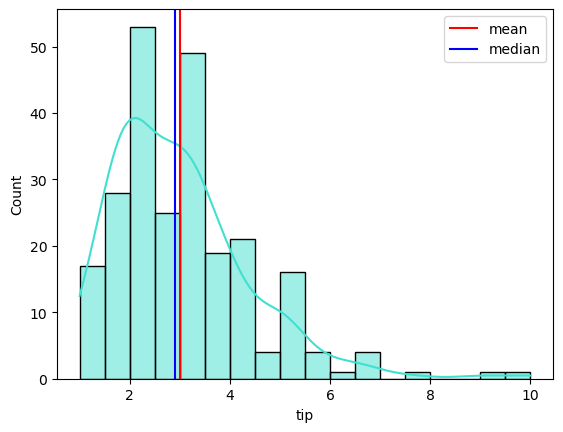

In [1121]:
graphic = sns.histplot(x=df_tips['tip'], color='turquoise', kde=True)
graphic.axvline(x=vmean, color="red", label="mean")
graphic.axvline(x=vmedian, color="blue", label="median")
plt.legend()
plt.show()

How my dependent variable isn't a normal distribution, I go to make a decision tree to predict the column 'tip'.

The method 'DecisionTreeRegressor' don't admit categorical values, I go to convert those columns to numeric values.

In [1092]:
# Create a new dataframe to keep the original dataframe.
df_new_tips = df_tips.copy()
df_new_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [1093]:
# Function to apply the method 'map'.
def apply_map(df, column, dictionary):
    new_column = column + "_map"
    df[new_column] = df[column].map(dictionary)
    return df

In [1094]:
# Create the map for the 'sex' column
map_sex = {"Male": 1, "Female": 0}
df_new_tips = apply_map(df_new_tips, "sex", map_sex)

In [1095]:
# Create the map for the 'smoker' column
map_smoker = {"No": 1, "Yes": 0}
df_new_tips = apply_map(df_new_tips, "smoker", map_smoker)

In [1096]:
# Create the map for the 'day' column
map_day = {"Sat": 3, "Sun": 2, "Thur": 1, "Fri": 0}
df_new_tips = apply_map(df_new_tips, "day", map_day)

In [1097]:
# Create the map for the 'time' column
map_time = {"Dinner": 1, "Lunch": 0}
df_new_tips = apply_map(df_new_tips, "time", map_time)

In [1098]:
# Remove the categorical columns.
df_new_tips = df_new_tips.drop(["sex", "smoker", "day", "time"], axis=1)

In [1099]:
df_new_tips.head()

,total_bill,tip,size,sex_map,smoker_map,day_map,time_map
0,16.99,1.01,2,0,1,2,1
1,10.34,1.66,3,1,1,2,1
2,21.01,3.50,3,1,1,2,1
3,23.68,3.31,2,1,1,2,1
4,24.59,3.61,4,0,1,2,1


And now I create the decision tree.

In [1100]:
# X: selection of independent variables.
X = df_new_tips.drop("tip", axis=1)

In [1101]:
# y: selection of dependent variable.
y = df_new_tips["tip"]

In [1102]:
# Split the dataset into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1103]:
# Create Decision Tree Regressor object.
clf_tree = DecisionTreeRegressor()

In [1104]:
# Train Decision Tree Regressor.
clf_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [1105]:
# Predict the dependent variable for test dataset.
y_predict_test = clf_tree.predict(X_test)

In [1106]:
# Predict the independent variables for train dataset.
y_predict_train = clf_tree.predict(X_train)

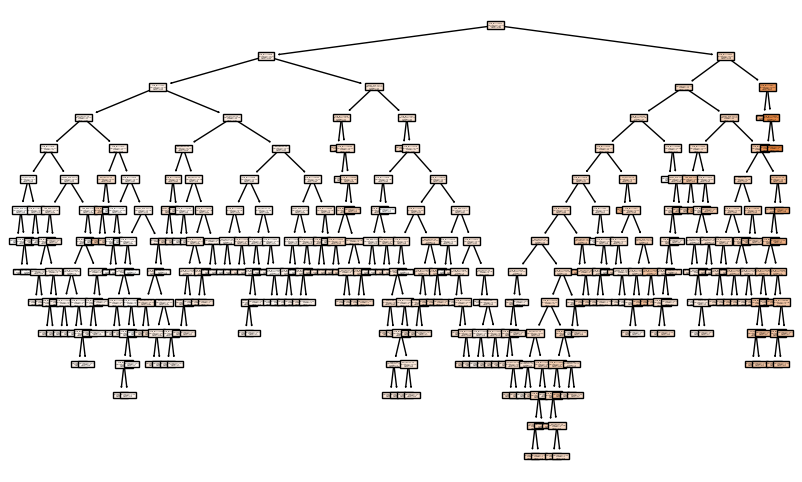

In [1107]:
# Plotting the tree.
fig = plt.figure(figsize = (10,6))
tree.plot_tree(clf_tree, feature_names = X_train.columns, filled = True)
plt.show()

In [1108]:
# Function to apply the metrics for DecisionTree.
def get_metrics(y_train_m, y_test_m, y_predict_train_m, y_predict_test_m, model):
    # In a diccionary, get the metrics to the train and test.
    results_metrics = {
        'MAE': [mean_absolute_error(y_test_m, y_predict_test_m), mean_absolute_error(y_train_m, y_predict_train_m)],
        'MSE': [mean_squared_error(y_test_m, y_predict_test_m), mean_squared_error(y_train_m, y_predict_train_m)],
        'RMSE': [np.sqrt(mean_squared_error(y_test_m, y_predict_test_m)), np.sqrt(mean_squared_error(y_train_m, y_predict_train_m))],
        'R2':  [r2_score(y_test_m, y_predict_test_m), r2_score(y_train_m, y_predict_train_m)],
        "set": ["test", "train"], 
        "modelo": [model, model]}

    df_results_metrics = pd.DataFrame(results_metrics)

    return df_results_metrics

In [1109]:
# In a dataframe save the metrics.
df_results1 = get_metrics(y_train, y_test, y_predict_train, y_predict_test, "Decision Tree Regressor I")
df_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.828571,1.194498,1.092931,0.04438,test,Decision Tree Regressor I
1,0.000000,0.000000,0.000000,1.00000,train,Decision Tree Regressor I


How R2 have a value of 1, my decision tree have a overfitting, then I can use GridSearchCV to reduce it.

In [1110]:
# Depth of the tree.
clf_tree.tree_.max_depth

14

In [1111]:
# Square root of the independent variables.
max_features = np.sqrt(len(X_train.columns))
max_features

2.449489742783178

In [1221]:
# Define dictionary with the hiperparams to modifie.
# min_samples_split: the minimum number of samples required to split an internal node
# min_samples_leaf: the minimum number of samples required to be at a leaf node. 
param = {"max_depth": [4,5,6,7], "max_features": [2,3], "min_samples_split": [2,3,4,5,6,7,8,10,12], 
         "min_samples_leaf": [2,3,4,5,6]}

In [1222]:
# Create Decision Tree Regressor object with GridSearchCV
grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param, cv=10, verbose=-1)

In [1223]:
# Train Decision Tree Regressor with GridSearchCV
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7], 'max_features': [2, 3],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 10, 12]},
             verbose=-1)

In [1224]:
best_model = grid.best_estimator_
best_model

DecisionTreeRegressor(max_depth=5, max_features=3, min_samples_leaf=6,
                      min_samples_split=8)

In [1225]:
# Predict the dependent variable for test dataset.
y_predict_test1 = best_model.predict(X_test)

In [1226]:
# Predict the independent variables for train dataset.
y_predict_train1 = best_model.predict(X_train)

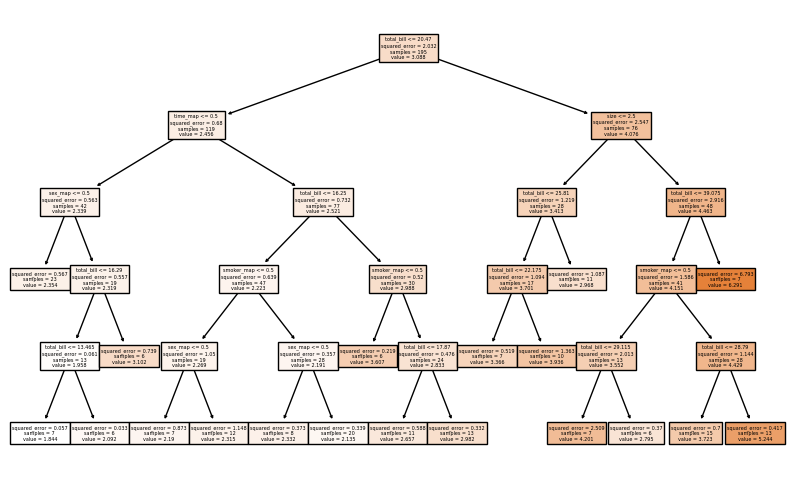

In [1227]:
# Plotting the tree.
fig = plt.figure(figsize = (10,6))
tree.plot_tree(best_model, feature_names = X_train.columns, filled = True)
plt.show()

In [1228]:
# In a dataframe save the metrics.
df_results2 = get_metrics(y_train, y_test, y_predict_train1, y_predict_test1, "Decision Tree Regressor II")
df_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.769555,0.806116,0.897839,0.355093,test,Decision Tree Regressor II
1,0.676722,0.883554,0.939976,0.565117,train,Decision Tree Regressor II


In [1229]:
df_results = pd.concat([df_results1, df_results2], axis=0)
df_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.828571,1.194498,1.092931,0.044380,test,Decision Tree Regressor I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree Regressor I
0,0.769555,0.806116,0.897839,0.355093,test,Decision Tree Regressor II
1,0.676722,0.883554,0.939976,0.565117,train,Decision Tree Regressor II


Now the metrics are better, but not enough. I can try with anothers hiperparams.

In [1230]:
# Get the importance of the independent variables.
importance_independent=pd.DataFrame({'independent':X_train.columns,'importance':best_model.feature_importances_})

# Order from largest to smallest.
importance_independent.sort_values(by=['importance'],ascending=False,inplace=True)
importance_independent

,independent,importance
0,total_bill,0.863930
1,size,0.087067
3,smoker_map,0.043612
5,time_map,0.004030
2,sex_map,0.001361
4,day_map,0.000000


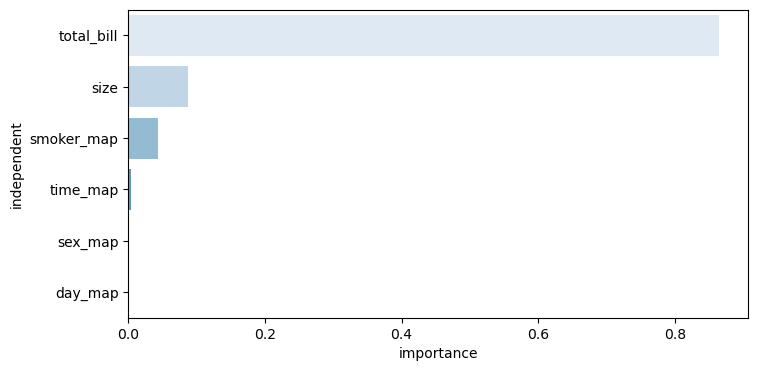

In [1234]:
# Graphic of importance
plt.figure(figsize=(8,4))
sns.barplot(x="importance", y="independent", data=importance_independent, palette="Blues")
plt.show();